<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS688/blob/main/767_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.preprocessing import OneHotEncoder

In [88]:
df = pd.read_csv("./Assignment_3_Hitters.csv")
df.rename( columns={'Unnamed: 0':'hitter_name'}, inplace=True )

# df = df.select_dtypes(include=np.number)
# df.reset_index(drop=True)

df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], prefix=["League_is", "Division_is", "NewLeague"] )

X_train = df.loc[~df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]
y_train = df.loc[~df.isnull().any(axis=1), ['Salary']]
X_test = df.loc[df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]


In [89]:
X_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_is_A,League_is_N,Division_is_E,Division_is_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,0,1,1,0,0,1
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,1,0,1,0,1,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,1,0,0,1,1,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,1,0,1,0,1,0


In [90]:
from enum import Enum
class Regularization(Enum):
     L2 = 1
     Lasso = 2

In [115]:
def predict(row, weights, bias):
  output = bias
  for index, weight in enumerate(weights):
    output += weight * row[index]
  return output if output > 0.0 else output * 0.05

def lasso_regularization(weights, lambda_val):
  return sum([abs(weight) for weight in weights]) * lambda_val
def l2_regularization(weights, lambda_val):
  return sum([weight**2 for weight in weights]) * (lambda_val/2)

def choose_regularzation(regularization, weights, lambda_val):
  if regularization == Regularization.L2:
    return l2_regularization(weights, lambda_val)
  else:
    return lasso_regularization(weights, lambda_val)

def train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs, learning_rate, lambda_val, regularization_component, alpha_val=0.9, batch_size=12, ):
  # weights for all the features 
  weights = [random.uniform(-2,2)* math.sqrt(2/16) for i in range(16)]
  bias = 0
  index = 0
  plot_values = []
  while index < num_epochs:
    mse = 0.0
    total_weights = 0.0
    total_gradient = [0 for _ in range(16)]
    mini_batch = X_train.sample(n = batch_size, random_state=42)
    regularization = choose_regularzation(regularization_component, weights, lambda_val)
    for rowIndex, row in mini_batch.iterrows():
      predicted_value = predict(row, weights, bias)
      error = (y_train.loc[rowIndex,'Salary'] - predicted_value)
      error_with_regularization = error + regularization
      mse += error**2
      mse_with_regularization = mse + regularization
      total_gradient = [gradient + (error_with_regularization * row[gradient_index]) for gradient_index, gradient in enumerate(total_gradient)] 
    total_gradient = [(alpha_val * gradient) + gradient for gradient in total_gradient] 
    bias = bias + learning_rate * (mse_with_regularization/mini_batch.shape[0])
    weights = [weight + learning_rate * (total_gradient[weight_index]/mini_batch.shape[0]) for weight_index, weight in enumerate(weights)]
    index = index + 1
    plot_values.append((index, mse_with_regularization/mini_batch.shape[0]))
    print('>epoch=%d, lrate=%.3f, error=%.3f' % (index, learning_rate, mse_with_regularization/mini_batch.shape[0]))
  df_plot_values = pd.DataFrame(plot_values, columns=['epoch', 'MSE'])
  return weights, bias, df_plot_values

In [ ]:
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, 2000, 0.00000001, 0.01, Regularization.Lasso, 5)

Text(0, 0.5, 'MSE with regularization')

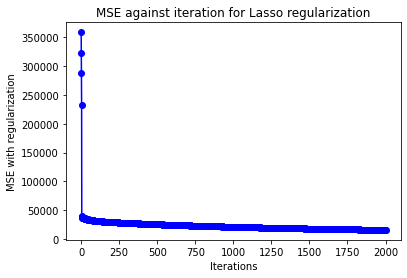

In [119]:
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration for Lasso regularization")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")

In [ ]:
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, 2000, 0.00000001, 0.01, Regularization.L2, 5)

Text(0, 0.5, 'MSE with regularization')

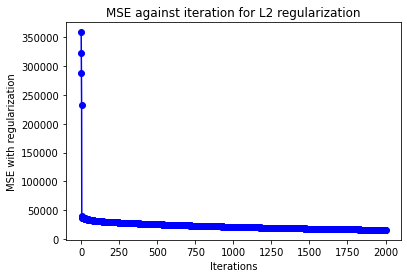

In [120]:
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration for L2 regularization")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")